In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the data

In [2]:
census_colname = 'ONS_Census_2011'
TARGET_COLNAME = 'TOTAL_Presented_Young_ppl_2014'
target_colname = '{0}'.format(TARGET_COLNAME)
population_colname = 'LA_Population_young'
population_total_colname = 'LA_Population'

In [3]:
DATA_RAW = pd.read_csv('../source data/new data/CP ETL output.csv')
mask = ((DATA_RAW[census_colname].str[0] == 'E') + (DATA_RAW[census_colname].str[0] == 'W'))
DATA_ENG_WAL_RAW = DATA_RAW[mask]
DATA_ENG_WAL = DATA_ENG_WAL_RAW[DATA_ENG_WAL_RAW[census_colname].notnull()]

# "test" subset — all records with known ONS codes
data_eng = DATA_ENG_WAL.copy()
#kick out the outlier: Milton Keynes
data_eng = data_eng[data_eng[census_colname] != 'E06000042']

/home/adam/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


Use young population as a predictor, not the total population:

In [4]:
data_eng = data_eng.rename(columns={'Missing Data: Presented HS 2014' : 'Missing_Data_Presented_HS_2014'})

In [5]:
YOUNG_POPULATION = pd.read_csv('../source data/new data/young_populations.csv')
data_eng = data_eng.merge(YOUNG_POPULATION, how='left', on=census_colname)
data_eng['Presented_Normalised'] = data_eng[target_colname]/data_eng[population_colname]

In [6]:
predictors = [population_colname]
test_filled = data_eng.dropna(subset=predictors, how='any')
train_filled = test_filled[test_filled['Missing_Data_Presented_HS_2014'] == 0]

### Linear Model based on Young Population - the only variable which is (obviously) correlated

#### All data

In [7]:
import statsmodels.formula.api as sm
model1 = sm.ols(formula="{0} ~ {1}".format(TARGET_COLNAME, ' + '.join([population_colname])), data=train_filled).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     TOTAL_Presented_Young_ppl_2014   R-squared:                       0.417
Model:                                        OLS   Adj. R-squared:                  0.413
Method:                             Least Squares   F-statistic:                     112.2
Date:                            Thu, 13 Aug 2015   Prob (F-statistic):           4.04e-20
Time:                                    10:15:09   Log-Likelihood:                -1124.2
No. Observations:                             159   AIC:                             2252.
Df Residuals:                                 157   BIC:                             2259.
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              14.3737     31.464      0.457      0.648       -47.774    76.522
LA_Population_young     0.0128      0.001     10.592      0.000         0.010     0.015
==============================================================================
Omnibus:                       84.327   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.998
Skew:                           1.939   Prob(JB):                     1.90e-93
Kurtosis:                      10.029   Cond. No.                     3.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Error estimation

See [here](http://stats.stackexchange.com/a/166949/71858) for the explanation of error estimation. I first calculate the standard deviation on the training data:
$$\hat{\sigma} = \sqrt{\frac{\sum (y-\hat{y})^2}{N-2}}$$

Then my upper and lower bounds for the **sum of homeless persons** are:
$$S=\sum (\hat{y}\pm 2\hat{\sigma})$$

Negative estimations don't make much sense, so for the lower bound, I'm taking $max(0, \hat{y}-2\hat{\sigma})$ (all the predictions that are below zero are zeroed).

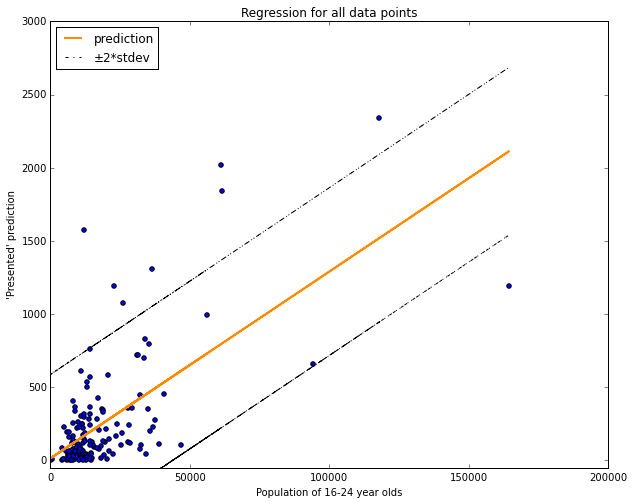

In [8]:
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = (10, 8)

predictor = 'LA_Population_young'
clf = LinearRegression()
clf.fit(train_filled[predictors], train_filled[TARGET_COLNAME])

prediction = clf.predict(train_filled[predictors])
stdev = np.sqrt(sum((train_filled[TARGET_COLNAME]-prediction)**2)/(len(prediction)-2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_filled[predictor], train_filled[target_colname])
ax.plot(train_filled[predictor], prediction, color='darkorange', lw=2, label='prediction')
ax.plot(train_filled[predictor], prediction+2*stdev, color='black', lw=1, ls='-.')
ax.plot(train_filled[predictor], prediction-2*stdev, color='black', lw=1, ls='-.', label='±2*stdev')
ax.set_xbound(lower=-50)
ax.set_ybound(lower=-50)
ax.legend(loc='best')
ax.set_ylabel("'Presented' prediction")
ax.set_xlabel("Population of 16-24 year olds")

ax.set_title('Regression for all data points')

#### Run the prediction on all data

After running the model, cerate upper/lower bound columns and save the results to a .csv file.

In [9]:
test_filled['prediction'] = clf.predict(test_filled[[population_colname]])
test_filled['prediction_processed'] = test_filled[TARGET_COLNAME].fillna(test_filled['prediction'])
test_filled['prediction_upper_bound'] = test_filled[TARGET_COLNAME].fillna(test_filled['prediction'].apply(lambda x: max(0, x+2*stdev)))
test_filled['prediction_lower_bound'] = test_filled[TARGET_COLNAME].fillna(test_filled['prediction'].apply(lambda x: max(0, x-2*stdev)))
test_filled.to_csv('linear_prediction_alldata.csv', columns=['ONS_Census_2011', 'Local_Authority', 'prediction_lower_bound', 'prediction_upper_bound', 'prediction', TARGET_COLNAME])
test_filled[['prediction_lower_bound', 'prediction_upper_bound', 'prediction', TARGET_COLNAME]].head(10)

,prediction_lower_bound,prediction_upper_bound,prediction,TOTAL_Presented_Young_ppl_2014
0,0,720.443442,147.450213,NaN
1,0,838.767702,265.774473,NaN
2,109,109.000000,429.580578,109
3,0,770.583219,197.589991,NaN
4,0,868.399813,295.406584,NaN
5,0,924.052541,351.059313,NaN
6,0,723.263724,150.270496,NaN
7,18,18.000000,187.610529,18
8,0,714.994298,142.001070,NaN
9,148,148.000000,284.967710,148


### Final prediction

In [10]:
test_filled[['prediction_lower_bound', 'prediction_upper_bound', 'prediction', TARGET_COLNAME]].sum()

prediction_lower_bound             43329.822700
prediction_upper_bound            164511.018976
prediction                         88648.083194
TOTAL_Presented_Young_ppl_2014     40882.500000
dtype: float64

#### "Reliable" data

Copy exactly what was done above, but take only those authorities for which the franction of presented is > 0.005 for building the model.

In [11]:
mask = train_filled['Presented_Normalised'] > 0.005
import statsmodels.formula.api as sm
model2 = sm.ols(formula="{0} ~ {1}".format(TARGET_COLNAME, ' + '.join([population_colname])), data=train_filled[mask]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     TOTAL_Presented_Young_ppl_2014   R-squared:                       0.448
Model:                                        OLS   Adj. R-squared:                  0.443
Method:                             Least Squares   F-statistic:                     84.35
Date:                            Thu, 13 Aug 2015   Prob (F-statistic):           4.47e-15
Time:                                    10:15:10   Log-Likelihood:                -758.69
No. Observations:                             106   AIC:                             1521.
Df Residuals:                                 104   BIC:                             1527.
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              97.6078     41.028      2.379      0.019        16.248   178.968
LA_Population_young     0.0128      0.001      9.184      0.000         0.010     0.016
==============================================================================
Omnibus:                       49.103   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.601
Skew:                           1.593   Prob(JB):                     2.45e-37
Kurtosis:                       8.294   Cond. No.                     3.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

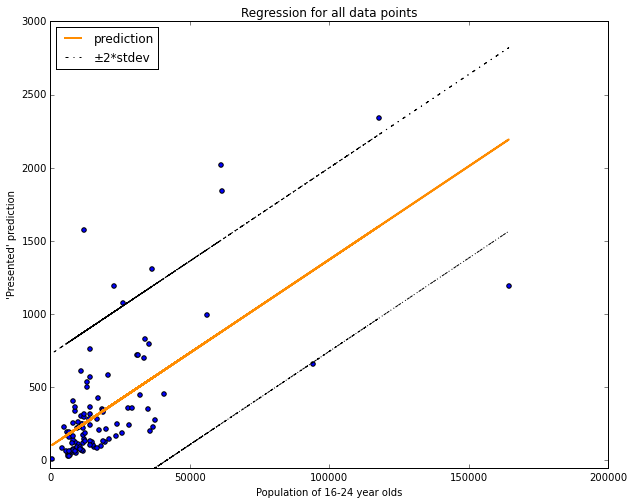

In [12]:
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = (10, 8)

predictor = 'LA_Population_young'
clf2 = LinearRegression()
clf2.fit(train_filled[mask][predictors], train_filled[mask][TARGET_COLNAME])

prediction = clf2.predict(train_filled[mask][predictors])
stdev = np.sqrt(sum((train_filled[mask][TARGET_COLNAME]-prediction)**2)/(len(prediction)-2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_filled[mask][predictor], train_filled[mask][target_colname])
ax.plot(train_filled[mask][predictor], prediction, color='darkorange', lw=2, label='prediction')
ax.plot(train_filled[mask][predictor], prediction+2*stdev, color='black', lw=1, ls='-.')
ax.plot(train_filled[mask][predictor], prediction-2*stdev, color='black', lw=1, ls='-.', label='±2*stdev')
ax.set_xbound(lower=-50)
ax.set_ybound(lower=-50)
ax.legend(loc='best')
ax.set_ylabel("'Presented' prediction")
ax.set_xlabel("Population of 16-24 year olds")

ax.set_title('Regression for all data points')

In [13]:
test_filled['prediction_topdata'] = clf.predict(test_filled[[population_colname]])
test_filled['prediction_processed_topdata'] = test_filled[TARGET_COLNAME].fillna(test_filled['prediction_topdata'])
test_filled['prediction_upper_bound_topdata'] = test_filled[TARGET_COLNAME].fillna(test_filled['prediction_topdata'].apply(lambda x: max(0, x+2*stdev)))
test_filled['prediction_lower_bound_topdata'] = test_filled[TARGET_COLNAME].fillna(test_filled['prediction_topdata'].apply(lambda x: max(0, x-2*stdev)))
test_filled.to_csv('linear_prediction_topdata.csv', columns=['ONS_Census_2011', 'Local_Authority', 'prediction_lower_bound_topdata', 'prediction_upper_bound_topdata', 'prediction_topdata', TARGET_COLNAME])
test_filled[['prediction_lower_bound_topdata', 'prediction_upper_bound_topdata', 'prediction_topdata', TARGET_COLNAME]].head(10)

,prediction_lower_bound_topdata,prediction_upper_bound_topdata,prediction_topdata,TOTAL_Presented_Young_ppl_2014
0,0,774.607278,147.450213,NaN
1,0,892.931538,265.774473,NaN
2,109,109.000000,429.580578,109
3,0,824.747056,197.589991,NaN
4,0,922.563649,295.406584,NaN
5,0,978.216378,351.059313,NaN
6,0,777.427561,150.270496,NaN
7,18,18.000000,187.610529,18
8,0,769.158135,142.001070,NaN
9,148,148.000000,284.967710,148


In [14]:
test_filled[['prediction_lower_bound_topdata', 'prediction_upper_bound_topdata', 'prediction_topdata', TARGET_COLNAME]].sum()

prediction_lower_bound_topdata     42870.094505
prediction_upper_bound_topdata    172473.102920
prediction_topdata                 88648.083194
TOTAL_Presented_Young_ppl_2014     40882.500000
dtype: float64